# **MONAI Data**

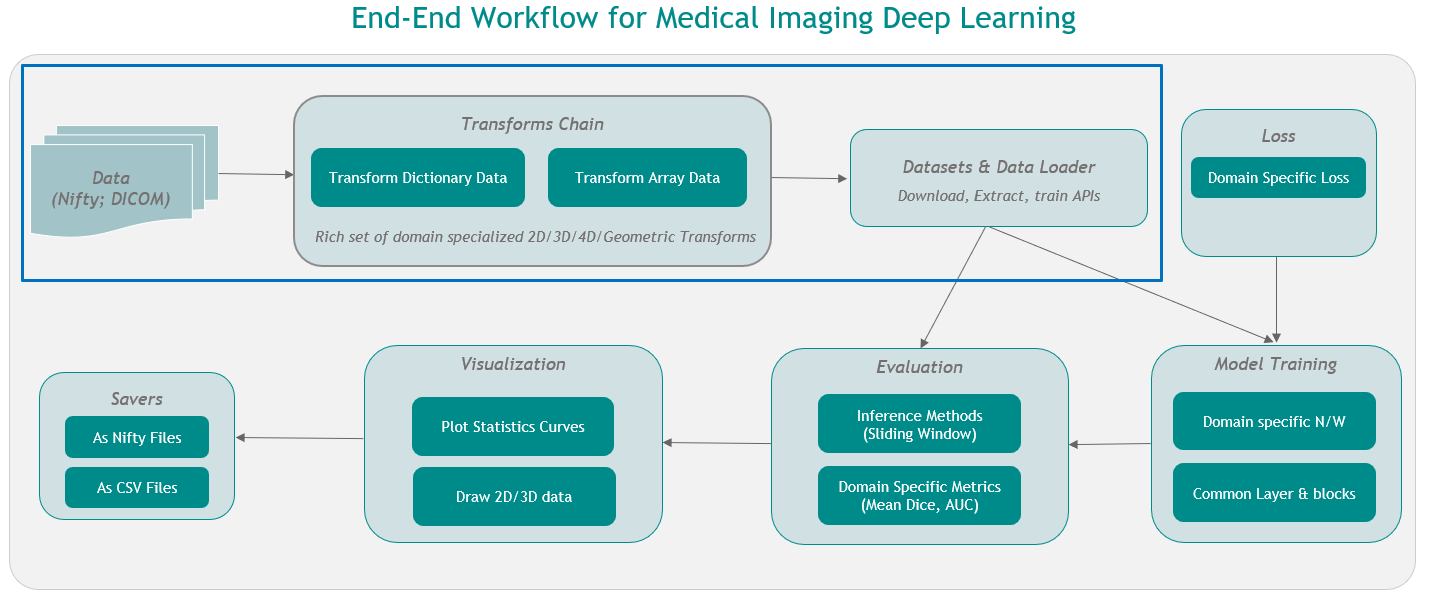

Medical images require highly specialized methods for I/O, preprocessing and augmentation. And users often need to train the model with many (potentially thousands of) epochs over the data to achieve the desired model quality. MONAI Data is a collection of Dataset, Dataloader, Image I/O, and many utilities about data processing. Let's explore the Data module! </br> 
MONAI Data: https://docs.monai.io/en/stable/data.html#

Environment: `projectmonai/monai:0.9.0`
https://hub.docker.com/r/projectmonai/monai

In [1]:
import monai
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm
import time

monai.__version__

'0.9.0'

## Image Reader & Image Writer
Defines APIs to load/write image files. The reader / writer are used in `monai.transforms.LoadImage` and `monai.transforms.SaveImage`. Including:
- ITKReader / ITKWriter
- NibabelReader / NibabelWriter
- PILReader / PILWriter
- WSIReader

### ITKReader / ITKWriter
Load / write medical images based on ITK library. Support many medical format like `DICOM`, `NRRD`, `Nifty`, and etc. (<a href="https://github.com/InsightSoftwareConsortium/ITK/tree/master/Modules/IO">supported formats</a>)

### NibabelReader / NibabelWriter
Load / write `Nifty` format images based on Nibabel library.

### PILReader / PILWriter
Load / write common 2D image format (supports `PNG`, `JPG`, `BMP`) file or files from provided path

### WSIReader
Read whole slide images and extract patches using different backend libraries

In [4]:
dummy = dummy = np.random.randint(low=0, high=256, size=[128, 128, 3], dtype='uint8')
plt.imsave('dummy.jpg', dummy)

(128, 128, 3)

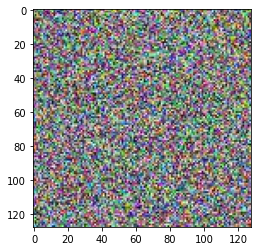

In [5]:
reader = monai.data.PILReader()
trans = monai.transforms.LoadImage(reader=reader)
loaded = trans('dummy.jpg')[0].astype('uint8')
plt.imshow(loaded)
loaded.shape

---

## Synthetic
A collection of creating testing data functions

### monai.data.synthetic.create_test_image_2d
Return a noisy 2D image with num_objs circles and a 2D mask image

In [6]:
dummy_img, dummy_seg = monai.data.synthetic.create_test_image_2d(width=128,
                                                                 height=128,
                                                                 num_objs=12,
                                                                 rad_max=15,
                                                                 rad_min=5,
                                                                 num_seg_classes=5)

print('dummy_img shape:', dummy_img.shape, ', dummy_img max:', dummy_img.max(), ', dummy_img min:', dummy_img.min())
print('dummy_seg shape:', dummy_seg.shape, ', dummy_seg max:', dummy_seg.max(), ', dummy_seg min:', dummy_seg.min())

dummy_img shape: (128, 128) , dummy_img max: 1.0 , dummy_img min: 0.0
dummy_seg shape: (128, 128) , dummy_seg max: 5 , dummy_seg min: 0


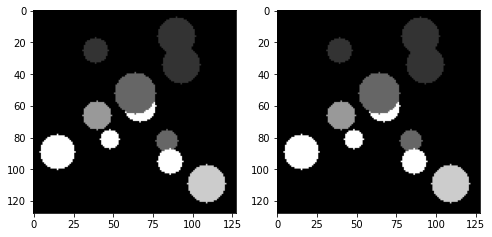

In [7]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(dummy_img, cmap='gray')
plt.subplot(122)
plt.imshow(dummy_seg, cmap='gray')

### monai.data.synthetic.create_test_image_3d
Return a noisy 3D image and segmentation

In [8]:
dummy_img, dummy_seg = monai.data.synthetic.create_test_image_3d(width=128,
                                                                 height=128,
                                                                 depth=128,
                                                                 num_objs=12,
                                                                 rad_max=15,
                                                                 rad_min=5,
                                                                 num_seg_classes=5)

print('dummy_img shape:', dummy_img.shape, ', dummy_img max:', dummy_img.max(), ', dummy_img min:', dummy_img.min())
print('dummy_seg shape:', dummy_seg.shape, ', dummy_seg max:', dummy_seg.max(), ', dummy_seg min:', dummy_seg.min())

dummy_img shape: (128, 128, 128) , dummy_img max: 1.0 , dummy_img min: 0.0
dummy_seg shape: (128, 128, 128) , dummy_seg max: 5 , dummy_seg min: 0


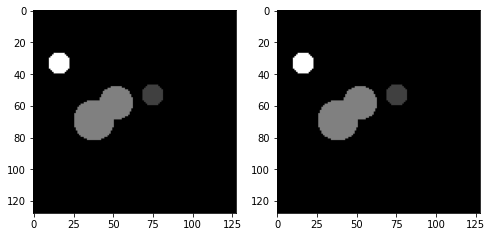

In [9]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(dummy_img[..., 64], cmap='gray')
plt.subplot(122)
plt.imshow(dummy_seg[..., 64], cmap='gray')

## Folder Layout

### monai.data.folder_layout.FolderLayout
A utility class to create organized filenames within `output_dir`. The `filename` method could be used to create a filename following the folder structure.

In [10]:
layout = monai.data.folder_layout.FolderLayout(output_dir="/test_run_1/",
                                               postfix="seg",
                                               extension="nii",
                                               makedirs=False)
layout.filename(subject="Sub-A", idx="0")

'/test_run_1/Sub-A_seg_0.nii'

In [11]:
fnames = []
for i in range(5):
    fnames.append(layout.filename(subject="Sub-A", idx=str(i)))
fnames    

['/test_run_1/Sub-A_seg_0.nii',
 '/test_run_1/Sub-A_seg_1.nii',
 '/test_run_1/Sub-A_seg_2.nii',
 '/test_run_1/Sub-A_seg_3.nii',
 '/test_run_1/Sub-A_seg_4.nii']

## Utilities

### monai.data.utils.affine_to_spacing
Computing the current spacing from the affine matrix.

In [12]:
data = {'img':'./data/img/spleen_3_0.nii.gz'}
trans = monai.transforms.LoadImaged(keys='img')

data = trans(data)
data['img_meta_dict']['affine']

array([[   0.73828101,    0.        ,    0.        , -377.26159668],
       [   0.        ,    0.73828101,    0.        , -377.26159668],
       [   0.        ,    0.        ,    5.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [13]:
monai.data.utils.affine_to_spacing(affine=data['img_meta_dict']['affine'], r=3)

array([0.73828101, 0.73828101, 5.        ])

### monai.data.utils.convert_tables_to_dicts
Utility to join pandas tables, select rows, columns and generate groups. Will return a list of dictionaries, every dictionary maps to a row of data in tables.

In [14]:
df = sns.load_dataset('iris')
df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [15]:
monai.data.utils.convert_tables_to_dicts(dfs=[df])[:3]

[{'sepal_length': 5.1,
  'sepal_width': 3.5,
  'petal_length': 1.4,
  'petal_width': 0.2,
  'species': 'setosa'},
 {'sepal_length': 4.9,
  'sepal_width': 3.0,
  'petal_length': 1.4,
  'petal_width': 0.2,
  'species': 'setosa'},
 {'sepal_length': 4.7,
  'sepal_width': 3.2,
  'petal_length': 1.3,
  'petal_width': 0.2,
  'species': 'setosa'}]

### monai.data.utils.decollate_batch
De-collate a batch of data, then return a list of structures with the original tensor's 0-th dimension sliced into elements.

In [16]:
batch_data = torch.randint(0, 256, size=(3, 1, 128, 128, 128))
decollated_data = monai.data.utils.decollate_batch(batch_data)
type(decollated_data), len(decollated_data)

(list, 3)

In [17]:
decollated_data[0].shape

torch.Size([1, 128, 128, 128])

### monai.data.DatasetSummary
This class provides a way to calculate a reasonable output voxel spacing according to the input dataset. In addition, it also supports to count the mean, std, min and max intensities of the input

In [18]:
img_path = './data/img/'
seg_path = './data/seg/'
datalist = [{'img':img_path+fname, 'seg':seg_path+fname} for fname in sorted(os.listdir(img_path)) if '.ipynb' not in fname]
keys = ['img', 'seg']
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys=keys)])
dataset = monai.data.Dataset(datalist, transform=trans)

summary = monai.data.DatasetSummary(dataset, image_key='img', label_key='seg')

In [19]:
summary.calculate_statistics()
summary.data_max, summary.data_min, summary.data_mean, summary.data_std

(250.0, -388.0, 138.67030334472656, 39.3694953918457)

In [20]:
summary.get_target_spacing()

(0.738281, 0.738281, 5.0)

### monai.data.load_decathlon_datalist
Load image/label paths of decathlon challenge from JSON file, which is similar to what you get from http://medicaldecathlon.com/ 

In [21]:
datalist = monai.data.load_decathlon_datalist('./dataset.json')

In [22]:
datalist[:3]

[{'image': 'imagesTr/la_007.nii.gz', 'label': 'labelsTr/la_007.nii.gz'},
 {'image': 'imagesTr/la_019.nii.gz', 'label': 'labelsTr/la_019.nii.gz'},
 {'image': 'imagesTr/la_023.nii.gz', 'label': 'labelsTr/la_023.nii.gz'}]

### monai.data.TestTimeAugmentation

In [23]:
data = {'img': './data/img/spleen_3_0.nii.gz'}
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys='img'),
                                  monai.transforms.AddChanneld(keys='img'),
                                  monai.transforms.RandFlipd(keys='img', prob=0.8, spatial_axis=(0, 1)),
                                  monai.transforms.RandSpatialCropd(keys='img', 
                                                                    roi_size=(64, 64, 32),
                                                                    random_center=True,
                                                                    random_size=False)])

model = monai.networks.nets.DenseNet121(spatial_dims=3,
                                        in_channels=1,
                                        out_channels=2)

tta = monai.data.TestTimeAugmentation(trans, batch_size=1, inferrer_fn=model, image_key='img', return_full_data=True)

In [24]:
result = tta(data, num_examples=3)
result

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


tensor([[-0.1230, -0.4578],
        [-0.1091, -0.4206],
        [-0.1146, -0.4450]])

# Dataset

"Users often need to train the model with many (potentially thousands of) epochs over the data to achieve the desired model quality. A native PyTorch implementation may repeatedly load data and run the same preprocessing steps for every epoch during training, which can be time-consuming and unnecessary, especially when the medical image volumes are large." <a href="https://docs.monai.io/en/latest/highlights.html#datasets-and-dataloader">Source</a>

Spleen dataset: http://medicaldecathlon.com/

#### Prepare datalist and transforms for the following examples

In [2]:
img_path = './data/img/'
seg_path = './data/seg/'
datalist = [{'img':img_path+fname, 'seg':seg_path+fname} for fname in sorted(os.listdir(img_path)) if '.ipynb' not in fname]
datalist[:3], len(datalist)

([{'img': './data/img/spleen_3_0.nii.gz',
   'seg': './data/seg/spleen_3_0.nii.gz'},
  {'img': './data/img/spleen_3_1.nii.gz',
   'seg': './data/seg/spleen_3_1.nii.gz'},
  {'img': './data/img/spleen_3_2.nii.gz',
   'seg': './data/seg/spleen_3_2.nii.gz'}],
 10)

In [3]:
keys = ['img', 'seg']
prob = 1.
# trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys=keys),  
#                                   monai.transforms.AddChanneld(keys=keys), 
#                                   monai.transforms.Spacingd(keys=keys, pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
#                                   monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
#                                                                         a_min=-57, a_max=164,
#                                                                         b_min=0.0, b_max=1.0),
#                                   monai.transforms.CropForegroundd(keys=keys, source_key='img'),
#                                   monai.transforms.RandGridDistortiond(keys, prob=prob, distort_limit=0.1, mode=['bilinear', 'nearest']),
#                                   monai.transforms.RandFlipd(keys, prob=prob, spatial_axis=(0, 1)),
#                                   monai.transforms.RandRotated(keys, prob=prob, range_z=1., keep_size=True, ),
#                                   monai.transforms.RandSpatialCropd(keys,
#                                                                     roi_size=(160, 160, 16),
#                                                                     random_center=True,
#                                                                     random_size=False),
#                                   monai.transforms.ToTensord(keys=keys)])

# GPU accelerated transforms
trans_gpu = monai.transforms.Compose([monai.transforms.LoadImaged(keys=keys),  
                                      monai.transforms.AddChanneld(keys=keys), 
                                      monai.transforms.ToTensord(keys=keys, device='cuda:0'),
                                      monai.transforms.Spacingd(keys=keys, pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
                                      monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                            a_min=-57, a_max=164,
                                                                            b_min=0.0, b_max=1.0),
                                      monai.transforms.CropForegroundd(keys=keys, source_key='img'),
                                      monai.transforms.RandGridDistortiond(keys, prob=prob, distort_limit=0.1, mode=['bilinear', 'nearest']),
                                      monai.transforms.RandFlipd(keys, prob=prob, spatial_axis=(0, 1)),
                                      monai.transforms.RandRotated(keys, prob=prob, range_z=1., keep_size=True, ),
                                      monai.transforms.RandSpatialCropd(keys,
                                                                        roi_size=(160, 160, 16),
                                                                        random_center=True,
                                                                        random_size=False),])

## Generic Dataset
---
- monai.data.Dataset
- monai.data.CacheDataset
- monai.data.PersistentDataset
- monai.data.SmartCacheDataset

### ***monai.data.Dataset***

In [4]:
dataset = monai.data.Dataset(datalist, transform=trans_gpu)
len(dataset)

10

In [5]:
# Use the dataset directly
for data in tqdm(dataset):
    _ = data

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


In [6]:
# Combine with DataLoader

def dataloader_dataset_demo(dataset, batch_size=2):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    for data in tqdm(loader):
        _ = data
    return data

data = dataloader_dataset_demo(dataset, batch_size=2)
data['img'].shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


torch.Size([2, 1, 160, 160, 16])

### Caching
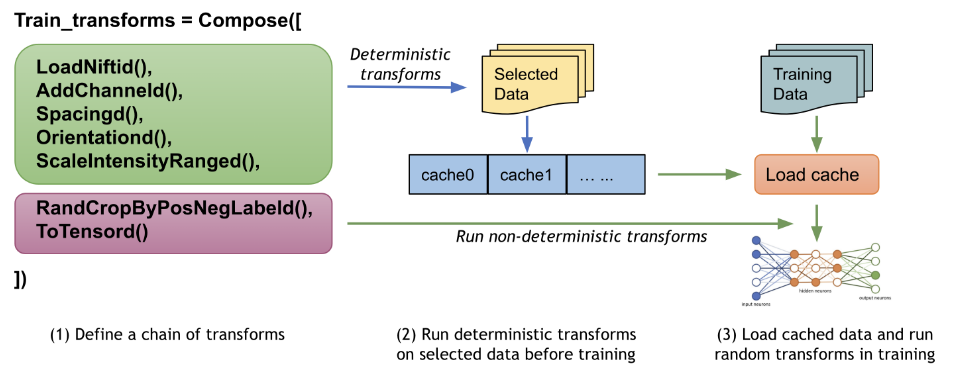

### ***monai.data.CacheDataset***

In [24]:
dataset = monai.data.CacheDataset(datalist, transform=trans_gpu)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.29it/s]


In [25]:
# Use the dataset directly
for data in tqdm(dataset):
    _ = data

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


In [26]:
# Combine with DataLoader
data = dataloader_dataset_demo(dataset, batch_size=2)
data['img'].shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]


torch.Size([2, 1, 160, 160, 16])

### ***monai.data.PersistentDataset***

In [27]:
cache_dir = './my_cache'

dataset = monai.data.PersistentDataset(datalist, transform=trans_gpu, cache_dir=cache_dir)

In [ ]:
!ls $cache_dir

In [29]:
# Use the dataset directly. The 1st time you execute the dataset, it will cache results in the cache_dir
for data in tqdm(dataset):
    _ = data

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]


In [30]:
!ls $cache_dir

196d50b2208087263cb874b280e4f521.pt  ac79782c4f7c799bf75e33d03b18cccd.pt
375bfebdc27b3b1142739f93003bad94.pt  b0ee865de7dc6adcc894814a8598751b.pt
38b2a9fe4cb4a31005c5b5f47ed4a721.pt  dac9ebbd05a1a30f0071e9932681eb23.pt
40d18fd32cfbd9044660c6bc570055ba.pt  eac0be6dde2777f7a200d989efc7661f.pt
8db6eaf4cb57d52266f038eab6b785d0.pt  f925a73439f3f84e034bd7bb346161be.pt


In [31]:
# Run again to check the performance
for data in tqdm(dataset):
    _ = data

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


In [32]:
# Combine with DataLoader
data = dataloader_dataset_demo(dataset, batch_size=2)
data['img'].shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


torch.Size([2, 1, 160, 160, 16])

### ***monai.data.SmartCacheDataset***

At any time, the cache pool **only keeps a subset of the whole dataset**. In each epoch, only the items in the cache are used for training. This ensures that data needed for training is readily available, **keeping GPU resources busy.**

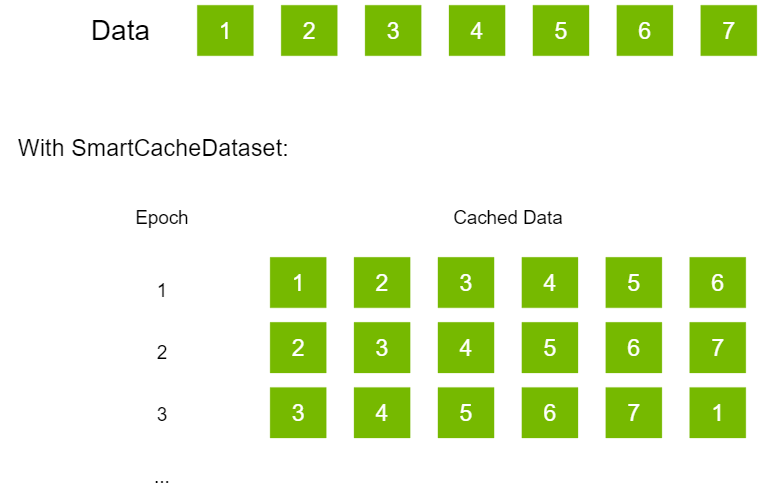

#### monai.data.SmartCacheDataset - A Toy Example

In [33]:
items = [{"data": 1}, 
         {"data": 2}, 
         {"data": 3}, 
         {"data": 4}, 
         {"data": 5}]

dataset = monai.data.SmartCacheDataset(items, transform=None, replace_rate=1/5, cache_rate=4/5)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 39756.44it/s]


In [34]:
# Use the dataset directly
dataset.start()
for i in range(5): 
    dataset.update_cache()
    data = []
    for item in dataset: 
        data.append(item['data'])
    print(data)
    print('------------------')
dataset.shutdown()

[1, 2, 4, 5]
------------------
[2, 4, 5, 3]
------------------
[4, 5, 3, 1]
------------------
[5, 3, 1, 2]
------------------
[3, 1, 2, 4]
------------------


In [35]:
# Combine with DataLoader
loader = torch.utils.data.DataLoader(dataset, batch_size=2)
dataset.start()
for i in range(5): 
    dataset.update_cache()
    data = []
    for item in tqdm(loader):
        data.append(item['data'])
    print(data)
    print('------------------')
dataset.shutdown()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2690.38it/s]


[tensor([1, 2]), tensor([4, 5])]
------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2542.00it/s]


[tensor([2, 4]), tensor([5, 3])]
------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2430.78it/s]


[tensor([4, 5]), tensor([3, 1])]
------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2456.40it/s]


[tensor([5, 3]), tensor([1, 2])]
------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2579.52it/s]

[tensor([3, 1]), tensor([2, 4])]
------------------


#### monai.data.SmartCacheDataset - Imaging Example

In [36]:
dataset = monai.data.SmartCacheDataset(datalist, transform=trans_gpu, replace_rate=1/5, cache_rate=0.8)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.26it/s]


In [23]:
# Use the dataset directly
dataset.start()
ts = []
for i in range(5): 
    t1 = time.time()
    dataset.update_cache()
    for data in dataset: 
        _ = data
    t2 = time.time()
    ts.append(t2-t1)
dataset.shutdown()
print('Throughputs:', round(len(dataset)/np.mean(ts), 2), 'img/s')

Throughputs: 5.91 img/s


#### ***Hint: SmartCacheDataset v.s. PersistentDataset***
Identify the cost of whole transforms (SmartCacheDataset) and I/O (PersistentDataset). Choose the cheap one!

## Patch-based Dataset
---
- monai.data.PatchDataset
- monai.data.GridPatchDataset

### **monai.data.PatchDataset**
Returns a patch from an image dataset. The patches are generated by a user-specified callable patch_func, and are optionally post-processed by transform. </br>
Split the transforms into sampler and trans:
- sampler: converts an input image into a sequence of image patches. We choose `monai.transforms.RandCropByPosNegLabeld` here.
- trans: remaining transforms

In [46]:
n_samples = 5 # convert an image into 5 patches

sampler = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                    monai.transforms.AddChanneld(keys=keys), 
                                    monai.transforms.ToTensord(keys=keys, device='cuda'),
                                    monai.transforms.Spacingd(keys=keys, pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
                                    monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                          a_min=-57, a_max=164,
                                                                          b_min=0.0, b_max=1.0),
                                    monai.transforms.CropForegroundd(keys=keys, source_key='img'),
                                    monai.transforms.RandGridDistortiond(keys, prob=prob, distort_limit=0.1, mode=['bilinear', 'nearest']),
                                    monai.transforms.RandCropByPosNegLabeld(keys, label_key='seg', spatial_size=(160, 160, 16), num_samples=n_samples)])

trans = monai.transforms.Compose([monai.transforms.RandFlipd(keys, prob=prob, spatial_axis=(0, 1)),])

dataset = monai.data.PatchDataset(data=datalist,
                                  patch_func=sampler,
                                  samples_per_image=n_samples,
                                  transform=trans)

In [47]:
len(dataset) # == len(datalist) * n_samples

50

In [48]:
len(datalist) * n_samples

50

In [49]:
data = dataloader_dataset_demo(dataset, batch_size=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.13s/it]


#### Advanced usage of PatchDataset
- Enable caching in PatchDataset

In [52]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys=keys),  
                                  monai.transforms.AddChanneld(keys=keys),
                                  monai.transforms.ToTensord(keys=keys, device='cuda'), 
                                  monai.transforms.Spacingd(keys=keys, pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
                                  monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                        a_min=-57, a_max=164,
                                                                        b_min=0.0, b_max=1.0),
                                  monai.transforms.CropForegroundd(keys=keys, source_key='img'),
                                  monai.transforms.RandGridDistortiond(keys, prob=prob, distort_limit=0.1, mode=['bilinear', 'nearest'])])

sampler = monai.transforms.RandCropByPosNegLabeld(keys, label_key='seg', spatial_size=(160, 160, 16), num_samples=n_samples)

trans_additional = monai.transforms.Compose([monai.transforms.RandFlipd(keys, prob=prob, spatial_axis=(0, 1))])

***Cache the pre-processed part using CacheDataset!**

In [53]:
dataset = monai.data.CacheDataset(datalist, transform=trans)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.29it/s]


Create a PatchDataset and use the CacheDataset as input)

In [54]:
p_dataset = monai.data.PatchDataset(data=dataset,
                                    patch_func=sampler,
                                    samples_per_image=n_samples,
                                    transform=trans_additional)
len(p_dataset)

50

In [55]:
data = dataloader_dataset_demo(p_dataset, batch_size=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.12it/s]


### **monai.data.GridPatchDataset**
Yields patches from images read from an image dataset. Typically used with `monai.data.PatchIter` so that the patches are chosen in a continuous grid sampling scheme.

In [56]:
# Prepare data for GridPatchDataset
# Dictionary-based dataset is not supported yet.
trans = monai.transforms.Compose([monai.transforms.LoadImage(image_only=True),  
                                  monai.transforms.AddChannel(),
                                  monai.transforms.ScaleIntensityRange(clip=True,
                                                                       a_min=-57, a_max=164,
                                                                       b_min=0.0, b_max=1.0),])
dataset = monai.data.CacheDataset([data['img'] for data in datalist], transform=trans)

dataset[0].shape, len(dataset)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.74it/s]


((1, 512, 512, 40), 10)

In [57]:
# PatchIter and GridPatchDataset
trans_additional = monai.transforms.Compose([monai.transforms.ToTensor()])

patch_iter = monai.data.PatchIter(patch_size=(256, 256, 40), start_pos=(0, 0, 0))

gp_dataset = monai.data.GridPatchDataset(data=dataset,
                                         patch_iter=patch_iter,
                                         transform=trans_additional)

##### Patches

40it [00:13,  2.97it/s]


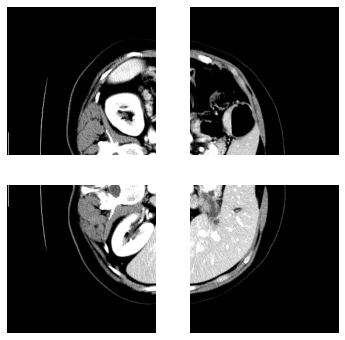

In [58]:
patches = []
for patch in tqdm(gp_dataset):
    patches.append(patch)

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(patches[0][0][0, ..., 20], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(222)
plt.imshow(patches[1][0][0, ..., 20], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(223)
plt.imshow(patches[2][0][0, ..., 20], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(224)
plt.imshow(patches[3][0][0, ..., 20], cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.show()

##### Original image

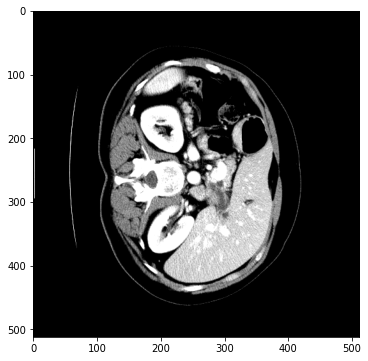

In [59]:
plt.figure(figsize=(6, 6))
plt.imshow(dataset[0][0, ..., 20], cmap='gray', vmin=0, vmax=1)

## Whole Slide Image Dataset

### monai.data.PatchWSIDataset
This dataset extracts patches from whole slide images (without loading the whole image) It also reads labels for each patch and provides each patch with its associated class labels.

In [61]:
data = [{
            "image": "data/tumor_001.tif",
            "patch_location": [
                124396,
                71708
            ],
            "label": [
                1,
                1,
                1,
                0,
                1,
                1,
                1,
                1,
                1
            ]
        },
        {
            "image": "data/tumor_001.tif",
            "patch_location": [
                127040,
                73408
            ],
            "label": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0
            ]
        },
        {
            "image": "data/tumor_001.tif",
            "patch_location": [
                126784,
                72512
            ],
            "label": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0
            ]
        },]

trans = monai.transforms.Compose(
            [
                monai.transforms.ToCupyd(keys='image', dtype=np.float32),
                monai.transforms.CuCIMd(keys='image', name="scale_intensity_range", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
                monai.transforms.ToTensord(keys='image', device='cuda'),
            ]
        )

ds = monai.data.PatchWSIDataset(data, transform=trans, patch_size=224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


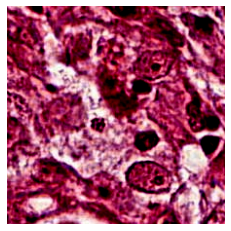

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


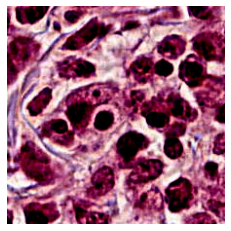

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


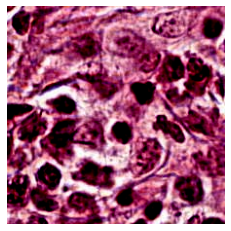

In [62]:
for d in ds:
    print(d['image'].shape)
    patch = d['image'].cpu().numpy().transpose([1, 2, 0])
    plt.imshow(patch)
    plt.axis('off')
    plt.show()

## DataLoader

### monai.data.ThreadDataLoader
If the transforms are **light-weighted**, especially when we cache all the data in RAM, the multiprocessing of PyTorch DataLoader may cause unnecessary IPC time and cause the drop of GPU utilization after every epoch. MONAI provides ThreadDataLoader which executes transforms in a separate thread

In [63]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys=keys),  
                                  monai.transforms.AddChanneld(keys=keys), 
                                  monai.transforms.Spacingd(keys=keys, pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
                                  monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                        a_min=-57, a_max=164,
                                                                        b_min=0.0, b_max=1.0),
                                  monai.transforms.CropForegroundd(keys=keys, source_key='img'),
                                  monai.transforms.RandFlipd(keys, prob=prob, spatial_axis=(0, 1)),
                                  monai.transforms.RandSpatialCropd(keys,
                                                                    roi_size=(160, 160, 16),
                                                                    random_center=True,
                                                                    random_size=False),])

dataset = monai.data.CacheDataset(datalist, transform=trans)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


In [64]:
# Native DataLoader on main process
loader = torch.utils.data.DataLoader(dataset, num_workers=0, batch_size=2)
for data in tqdm(loader):
    _ = data

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.61it/s]


In [65]:
# Native DataLoader with 2 workers
loader = torch.utils.data.DataLoader(dataset, num_workers=2, batch_size=2)
for data in tqdm(loader):
    _ = data

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


In [66]:
# Native DataLoader with 4 workers
loader = torch.utils.data.DataLoader(dataset, num_workers=4, batch_size=2)
for data in tqdm(loader):
    _ = data

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


In [68]:
# ThreadDataloader
loader = monai.data.ThreadDataLoader(dataset, num_workers=0, batch_size=2)
for data in tqdm(loader):
    _ = data

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.50it/s]
